<a href="https://colab.research.google.com/github/amuthalingeswaranbose/Amuthan_NLP_Learnings/blob/main/NLP_Fine_tuning_LayoutLMForTokenClassification_on_FUNSD_MedBillOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [1]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

rm: cannot remove 'unilm': No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 7582, done.
remote: Total 7582 (delta 0), reused 0 (delta 0), pack-reused 7582
Receiving objects: 100% (7582/7582), 17.40 MiB | 10.29 MiB/s, done.
Resolving deltas: 100% (3403/3403), done.
Processing ./unilm/layoutlm
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.7/195.7 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

no

In [2]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 177897, done.
remote: Counting objects: 100% (922/922), done.
remote: Compressing objects: 100% (467/467), done.
remote: Total 177897 (delta 532), reused 686 (delta 367), pack-reused 176975
Receiving objects: 100% (177897/177897), 210.44 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (121886/121886), done.
Updating files: 100% (3994/3994), done.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.37.0.dev0-py3-none-any.whl size=8340729 sha256=46c411abb4d65ffaf9380795bf0462fb9ad1b2cd8fc053989fb29354968b4b00
  Stored in directory: /tmp/pip-ephem-wheel-cache-jdo2whi3/wheels/7c/35/80/e946b22a081210c6642e607ed65b2a5b9a4d9259695ee2caf5
Successfully built transformers
  Attempting uninstall: transformers
    F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/MedBillOCR_Images/Notebook/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
# ! wget https://guillaumejaume.github.io/FUNSD/dataset.zip

# ! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX
# ! unzip /content/dataset/MedBillOCR_nvPg6ef.zip #&& mv /content/dataset #&& rm -rf dataset.zip __MACOSX

Archive:  /content/dataset/MedBillOCR_nvPg6ef.zip
 extracting: img-28.json             
 extracting: img-2_image_0.jpg       
 extracting: img-37.json             
 extracting: img-19.json             
 extracting: img-11_image_0.jpg      
 extracting: img-8_image_0.jpg       
 extracting: img-84.json             
 extracting: img-93.json             
 extracting: img-75.json             
 extracting: img-7_image_0.jpg       
 extracting: img-120.json            
 extracting: img-102.json            
 extracting: img-111.json            
 extracting: img-56.json             
 extracting: img-3_image_0.jpg       
 extracting: img-12_image_0.jpg      
 extracting: img-9_image_0.jpg       
 extracting: img-1_image_0.jpg       
 extracting: img-10_image_0.jpg      
 extracting: img-5_image_0.jpg       


Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

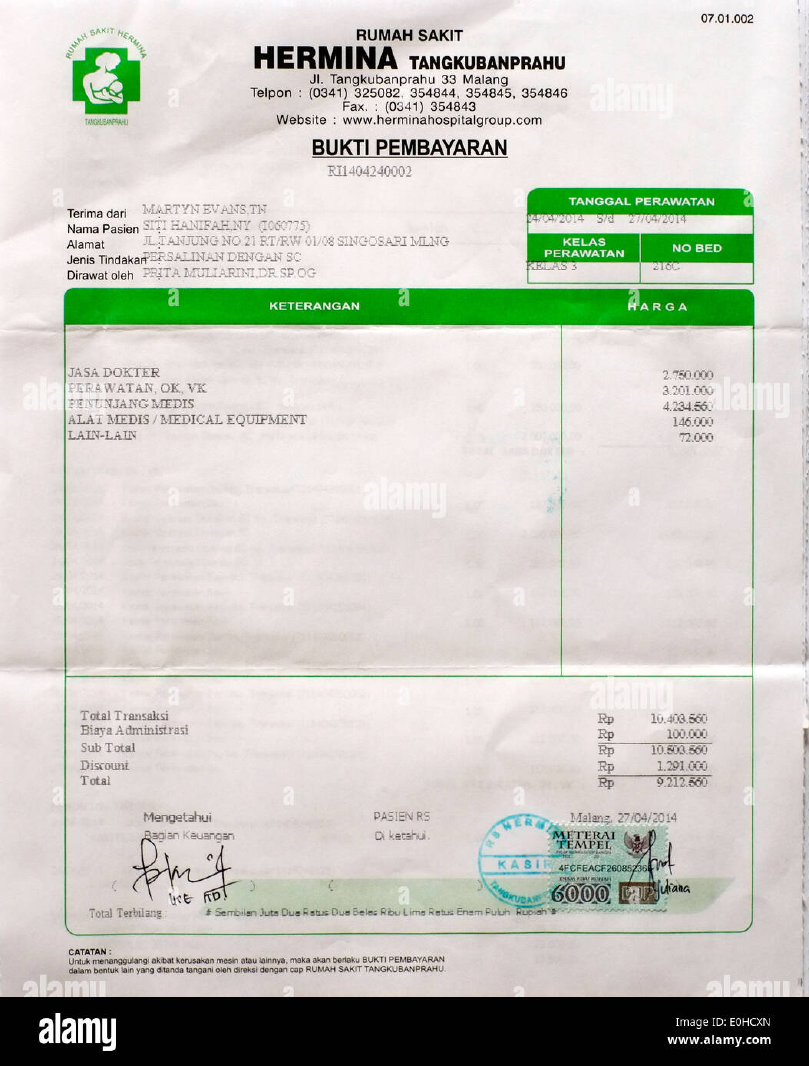

In [5]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/dataset/training_data/images/img-1.jpg")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.


In [6]:
import json

with open('/content/dataset/training_data/annotations/img-1.json') as f:
  data = json.load(f)

# data[0]['form']

for annotation in data[0]['form']:
  print(annotation)

{'box': [254, 28, 565, 69], 'text': 'RUMAH SAKIT\nHERMINA TANGKUBANPRAHU', 'label': 'HOSPITAL', 'words': [{'box': [356, 28, 412, 40], 'text': 'RUMAH'}, {'box': [418, 28, 463, 41], 'text': 'SAKIT'}, {'box': [254, 45, 398, 69], 'text': 'HERMINA'}, {'box': [408, 55, 565, 69], 'text': 'TANGKUBANPRAHU'}], 'linking': [], 'id': 0}
{'box': [142, 203, 267, 214], 'text': 'MARTYN EVANSTN', 'label': 'PERSON', 'words': [{'box': [142, 203, 199, 214], 'text': 'MARTYN'}, {'box': [202, 204, 267, 214], 'text': 'EVANSTN'}], 'linking': [], 'id': 1}
{'box': [528, 214, 583, 223], 'text': '04/04/2014', 'label': 'START DATE', 'words': [{'box': [528, 214, 583, 223], 'text': '04/04/2014'}], 'linking': [], 'id': 2}
{'box': [68, 367, 159, 377], 'text': 'JASA DOKTER', 'label': 'SERVICES GIVEN', 'words': [{'box': [68, 367, 99, 377], 'text': 'JASA'}, {'box': [103, 367, 159, 377], 'text': 'DOKTER'}], 'linking': [], 'id': 3}
{'box': [69, 382, 206, 393], 'text': 'PERAWATAN, OK VK', 'label': 'SERVICES GIVEN', 'words': [

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

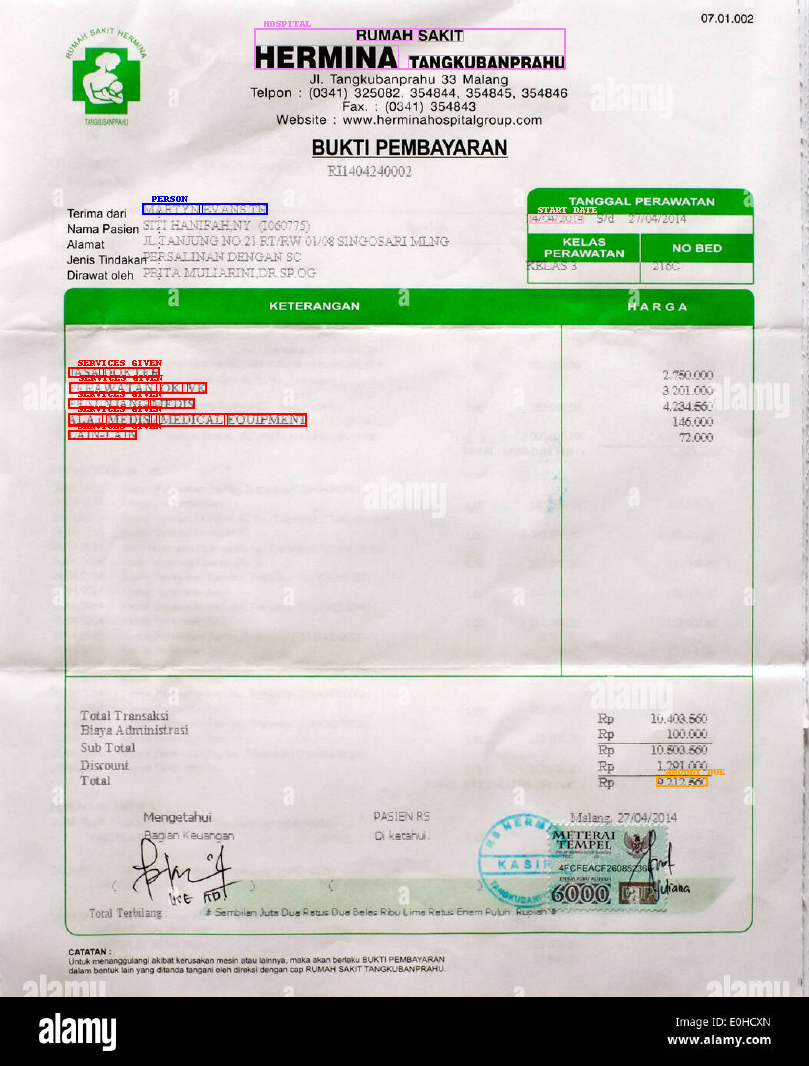

In [7]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'PERSON':'blue',
               'PROVIDER':'green',
               'AMOUNT DUE':'orange',
               'HOSPITAL':'violet',
               'SERVICES GIVEN':'red',
               'START DATE':'pink',
               'INVOICE NUMBER':'yello'}

for annotation in data[0]['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [ ]:
# the below line it want png as a input

In [13]:
mkdir data

In [14]:
! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir dataset/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir dataset/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

tokenizer_config.json: 100% 170/170 [00:00<00:00, 808kB/s]
config.json: 100% 606/606 [00:00<00:00, 3.29MB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 36.5MB/s]
tokenizer.json: 100% 466k/466k [00:00<00:00, 30.9MB/s]
special_tokens_map.json: 100% 112/112 [00:00<00:00, 653kB/s]


Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [15]:
! cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [16]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER:

In [17]:
print(labels)

['O', 'B-AMOUNT DUE', 'B-HOSPITAL', 'B-INVOICE NUMBER', 'B-PERSON', 'B-PROVIDER', 'B-SERVICES GIVEN', 'B-START DATE', 'E-AMOUNT DUE', 'E-HOSPITAL', 'E-INVOICE NUMBER', 'E-PERSON', 'E-PROVIDER', 'E-SERVICES GIVEN', 'E-START DATE', 'I-HOSPITAL', 'I-INVOICE NUMBER', 'I-PERSON', 'I-PROVIDER', 'I-SERVICES GIVEN', 'I-START DATE', 'S-AMOUNT DUE', 'S-HOSPITAL', 'S-PERSON', 'S-PROVIDER', 'S-SERVICES GIVEN', 'S-START DATE']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [19]:
import logging
import os

import torch
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)


class FunsdDataset(Dataset):
    def __init__(self, args, tokenizer, labels, pad_token_label_id, mode):
        if args.local_rank not in [-1, 0] and mode == "train":
            torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

        # Load data features from cache or dataset file
        cached_features_file = os.path.join(
            args.data_dir,
            "cached_{}_{}_{}".format(
                mode,
                list(filter(None, args.model_name_or_path.split("/"))).pop(),
                str(args.max_seq_length),
            ),
        )
        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            features = torch.load(cached_features_file)
        else:
            logger.info("Creating features from dataset file at %s", args.data_dir)
            examples = read_examples_from_file(args.data_dir, mode)
            features = convert_examples_to_features(
                examples,
                labels,
                args.max_seq_length,
                tokenizer,
                cls_token_at_end=bool(args.model_type in ["xlnet"]),
                # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args.model_type in ["xlnet"] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args.model_type in ["roberta"]),
                # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args.model_type in ["xlnet"]),
                # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args.model_type in ["xlnet"] else 0,
                pad_token_label_id=pad_token_label_id,
            )
            #if args.local_rank in [-1, 0]:
                #logger.info("Saving features into cached file %s", cached_features_file)
                #torch.save(features, cached_features_file)

        if args.local_rank == 0 and mode == "train":
            torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

        self.features = features
        # Convert to Tensors and build dataset
        self.all_input_ids = torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        )
        self.all_input_mask = torch.tensor(
            [f.input_mask for f in features], dtype=torch.long
        )
        self.all_segment_ids = torch.tensor(
            [f.segment_ids for f in features], dtype=torch.long
        )
        self.all_label_ids = torch.tensor(
            [f.label_ids for f in features], dtype=torch.long
        )
        self.all_bboxes = torch.tensor([f.boxes for f in features], dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return (
            self.all_input_ids[index],
            self.all_input_mask[index],
            self.all_segment_ids[index],
            self.all_label_ids[index],
            self.all_bboxes[index],
        )


class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels, boxes, actual_bboxes, file_name, page_size):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(
        self,
        input_ids,
        input_mask,
        segment_ids,
        label_ids,
        boxes,
        actual_bboxes,
        file_name,
        page_size,
    ):
        assert (
            0 <= all(boxes) <= 1000
        ), "Error with input bbox ({}): the coordinate value is not between 0 and 1000".format(
            boxes
        )
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    box_file_path = os.path.join(data_dir, "{}_box.txt".format(mode))
    image_file_path = os.path.join(data_dir, "{}_image.txt".format(mode))
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f, open(
        box_file_path, encoding="utf-8"
    ) as fb, open(image_file_path, encoding="utf-8") as fi:
        words = []
        boxes = []
        actual_bboxes = []
        file_name = None
        page_size = None
        labels = []
        for line, bline, iline in zip(f, fb, fi):
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if words:
                    examples.append(
                        InputExample(
                            guid="{}-{}".format(mode, guid_index),
                            words=words,
                            labels=labels,
                            boxes=boxes,
                            actual_bboxes=actual_bboxes,
                            file_name=file_name,
                            page_size=page_size,
                        )
                    )
                    guid_index += 1
                    words = []
                    boxes = []
                    actual_bboxes = []
                    file_name = None
                    page_size = None
                    labels = []
            else:
                splits = line.split("\t")
                bsplits = bline.split("\t")
                isplits = iline.split("\t")
                assert len(splits) == 2
                assert len(bsplits) == 2
                assert len(isplits) == 4
                assert splits[0] == bsplits[0]
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                    box = bsplits[-1].replace("\n", "")
                    box = [int(b) for b in box.split()]
                    boxes.append(box)
                    actual_bbox = [int(b) for b in isplits[1].split()]
                    actual_bboxes.append(actual_bbox)
                    page_size = [int(i) for i in isplits[2].split()]
                    file_name = isplits[3].strip()
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(
                InputExample(
                    guid="%s-%d".format(mode, guid_index),
                    words=words,
                    labels=labels,
                    boxes=boxes,
                    actual_bboxes=actual_bboxes,
                    file_name=file_name,
                    page_size=page_size,
                )
            )
    return examples


def convert_examples_to_features(
    examples,
    label_list,
    max_seq_length,
    tokenizer,
    cls_token_at_end=False,
    cls_token="[CLS]",
    cls_token_segment_id=1,
    sep_token="[SEP]",
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=0,
    cls_token_box=[0, 0, 0, 0],
    sep_token_box=[1000, 1000, 1000, 1000],
    pad_token_box=[0, 0, 0, 0],
    pad_token_segment_id=0,
    pad_token_label_id=-1,
    sequence_a_segment_id=0,
    mask_padding_with_zero=True,
):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        file_name = example.file_name
        page_size = example.page_size
        width, height = page_size
        if ex_index % 10000 == 0:
            logger.info("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        token_boxes = []
        actual_bboxes = []
        label_ids = []
        for word, label, box, actual_bbox in zip(
            example.words, example.labels, example.boxes, example.actual_bboxes
        ):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            token_boxes.extend([box] * len(word_tokens))
            actual_bboxes.extend([actual_bbox] * len(word_tokens))
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend(
                [label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1)
            )

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
            token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
            actual_bboxes = actual_bboxes[: (max_seq_length - special_tokens_count)]
            label_ids = label_ids[: (max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        token_boxes += [sep_token_box]
        actual_bboxes += [[0, 0, width, height]]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            token_boxes += [sep_token_box]
            actual_bboxes += [[0, 0, width, height]]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            token_boxes += [cls_token_box]
            actual_bboxes += [[0, 0, width, height]]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            token_boxes = [cls_token_box] + token_boxes
            actual_bboxes = [[0, 0, width, height]] + actual_bboxes
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = (
                [0 if mask_padding_with_zero else 1] * padding_length
            ) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
            token_boxes = ([pad_token_box] * padding_length) + token_boxes
        else:
            input_ids += [pad_token] * padding_length
            input_mask += [0 if mask_padding_with_zero else 1] * padding_length
            segment_ids += [pad_token_segment_id] * padding_length
            label_ids += [pad_token_label_id] * padding_length
            token_boxes += [pad_token_box] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length
        assert len(token_boxes) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s", example.guid)
            logger.info("tokens: %s", " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s", " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s", " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s", " ".join([str(x) for x in segment_ids]))
            logger.info("label_ids: %s", " ".join([str(x) for x in label_ids]))
            logger.info("boxes: %s", " ".join([str(x) for x in token_boxes]))
            logger.info("actual_bboxes: %s", " ".join([str(x) for x in actual_bboxes]))

        features.append(
            InputFeatures(
                input_ids=input_ids,
                input_mask=input_mask,
                segment_ids=segment_ids,
                label_ids=label_ids,
                boxes=token_boxes,
                actual_bboxes=actual_bboxes,
                file_name=file_name,
                page_size=page_size,
            )
        )
    return features


In [20]:
from transformers import LayoutLMTokenizer
# from unilm.layoutlm.data.funsd import FunsdDataset, InputFeatures
# from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [21]:
len(train_dataloader)

4

In [22]:
len(eval_dataloader)

1

In [23]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] claim : 123120, provider : facility : 26676 pin hand dislocation 26676 pin hand dislocation patient payment patient payment your balance due on these services claim : 126447, provider : facility : 6 73130 x - ray hand, right 3 view 99024 post - op 29075 application cast / short arm q4010 supplies cast short arm ( 11 + yrs ) your balance due on these services claim : 136711, provider : facility : 6 73130 x - ray hand, right 3 view 99024 post - op your balance due on these services claim : 135307, provider : facility : 20670 removal superficial implant your balance due on these services 6297. 00 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [24]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

pytorch_model.bin:   0%|          | 0.00/453M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

Now we can start training:

In [25]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 100
t_total = len(train_dataloader) * num_train_epochs # total number of training steps

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/4 [00:00<?, ?it/s]

Loss after 0 steps: 3.251948118209839


Training:  25%|██▌       | 1/4 [00:00<00:00,  5.46it/s]

Loss after 100 steps: 0.05635658651590347


Training:  25%|██▌       | 1/4 [00:00<00:00,  5.17it/s]

Loss after 200 steps: 0.009188279509544373


Training:  25%|██▌       | 1/4 [00:00<00:00,  5.21it/s]

Loss after 300 steps: 0.01112725306302309


Training: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


## Evaluation

Now let's evaluate on the test set:

In [26]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ea329e9a0ea851deae46ed179378b56a81fa2c4085dd8f630a2a809ddc0fa853
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [27]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

{'loss': 0.9169350266456604, 'precision': 0.5454545454545454, 'recall': 0.7058823529411765, 'f1': 0.6153846153846153}


In [29]:
# PATH='/content/drive/MyDrive/MedBillOCR_Images/100epoch/layoutlm.pt'
# torch.save(model.state_dict(), PATH)

In [30]:
# Save
PATH='/content/drive/MyDrive/MedBillOCR_Images/full_100epoch/layoutlm.pt'
torch.save(model, PATH)

In [42]:
from huggingface_hub import notebook_login
notebook_login()

## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [31]:
!git clone https://github.com/UBIAI/layout_lm_tutorial.git

Cloning into 'layout_lm_tutorial'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), done.


In [32]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,822 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [33]:
import argparse
import json
import os

from PIL import Image
from transformers import AutoTokenizer


def bbox_string(box, width, length):
    return (
        str(int(1000 * (box[0] / width)))
        + " "
        + str(int(1000 * (box[1] / length)))
        + " "
        + str(int(1000 * (box[2] / width)))
        + " "
        + str(int(1000 * (box[3] / length)))
    )


def actual_bbox_string(box, width, length):
    return (
        str(box[0])
        + " "
        + str(box[1])
        + " "
        + str(box[2])
        + " "
        + str(box[3])
        + "\t"
        + str(width)
        + " "
        + str(length)
    )


def convert(args):
    with open(
        os.path.join(args.output_dir, args.data_split + ".txt.tmp"),
        "w",
        encoding="utf8",
    ) as fw, open(
        os.path.join(args.output_dir, args.data_split + "_box.txt.tmp"),
        "w",
        encoding="utf8",
    ) as fbw, open(
        os.path.join(args.output_dir, args.data_split + "_image.txt.tmp"),
        "w",
        encoding="utf8",
    ) as fiw:
        for file in os.listdir(args.data_dir):
            file_path = os.path.join(args.data_dir, file)
            with open(file_path, "r", encoding="utf8") as f:
                data = json.load(f)
            image_path = file_path.replace("annotations", "images")
            # image_path = image_path.replace("json", "png")
            image_path = image_path.replace("json", "jpg")
            file_name = os.path.basename(image_path)
            image = Image.open(image_path)
            width, length = image.size
            for item in data[0]["form"]:
                words, label = item["words"], item["label"]
                words = [w for w in words if w["text"].strip() != ""]
                if len(words) == 0:
                    continue
                if label == "other":
                    for w in words:
                        fw.write(w["text"] + "\tO\n")
                        fbw.write(
                            w["text"]
                            + "\t"
                            + bbox_string(w["box"], width, length)
                            + "\n"
                        )
                        fiw.write(
                            w["text"]
                            + "\t"
                            + actual_bbox_string(w["box"], width, length)
                            + "\t"
                            + file_name
                            + "\n"
                        )
                else:
                    if len(words) == 1:
                        fw.write(words[0]["text"] + "\tS-" + label.upper() + "\n")
                        fbw.write(
                            words[0]["text"]
                            + "\t"
                            + bbox_string(words[0]["box"], width, length)
                            + "\n"
                        )
                        fiw.write(
                            words[0]["text"]
                            + "\t"
                            + actual_bbox_string(words[0]["box"], width, length)
                            + "\t"
                            + file_name
                            + "\n"
                        )
                    else:
                        fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                        fbw.write(
                            words[0]["text"]
                            + "\t"
                            + bbox_string(words[0]["box"], width, length)
                            + "\n"
                        )
                        fiw.write(
                            words[0]["text"]
                            + "\t"
                            + actual_bbox_string(words[0]["box"], width, length)
                            + "\t"
                            + file_name
                            + "\n"
                        )
                        for w in words[1:-1]:
                            fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                            fbw.write(
                                w["text"]
                                + "\t"
                                + bbox_string(w["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                w["text"]
                                + "\t"
                                + actual_bbox_string(w["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                        fw.write(words[-1]["text"] + "\tE-" + label.upper() + "\n")
                        fbw.write(
                            words[-1]["text"]
                            + "\t"
                            + bbox_string(words[-1]["box"], width, length)
                            + "\n"
                        )
                        fiw.write(
                            words[-1]["text"]
                            + "\t"
                            + actual_bbox_string(words[-1]["box"], width, length)
                            + "\t"
                            + file_name
                            + "\n"
                        )
            fw.write("\n")
            fbw.write("\n")
            fiw.write("\n")


def seg_file(file_path, tokenizer, max_len):
    subword_len_counter = 0
    output_path = file_path[:-4]
    with open(file_path, "r", encoding="utf8") as f_p, open(
        output_path, "w", encoding="utf8"
    ) as fw_p:
        for line in f_p:
            line = line.rstrip()

            if not line:
                fw_p.write(line + "\n")
                subword_len_counter = 0
                continue
            token = line.split("\t")[0]

            current_subwords_len = len(tokenizer.tokenize(token))

            # Token contains strange control characters like \x96 or \x95
            # Just filter out the complete line
            if current_subwords_len == 0:
                continue

            if (subword_len_counter + current_subwords_len) > max_len:
                fw_p.write("\n" + line + "\n")
                subword_len_counter = current_subwords_len
                continue

            subword_len_counter += current_subwords_len

            fw_p.write(line + "\n")


def seg(args):
    tokenizer = AutoTokenizer.from_pretrained(
        args.model_name_or_path, do_lower_case=True
    )
    seg_file(
        os.path.join(args.output_dir, args.data_split + ".txt.tmp"),
        tokenizer,
        args.max_len,
    )
    seg_file(
        os.path.join(args.output_dir, args.data_split + "_box.txt.tmp"),
        tokenizer,
        args.max_len,
    )
    seg_file(
        os.path.join(args.output_dir, args.data_split + "_image.txt.tmp"),
        tokenizer,
        args.max_len,
    )


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#         "--data_dir", type=str, default="data/training_data/annotations"
#     )
#     parser.add_argument("--data_split", type=str, default="train")
#     parser.add_argument("--output_dir", type=str, default="data")
#     parser.add_argument("--model_name_or_path", type=str, default="bert-base-uncased")
#     parser.add_argument("--max_len", type=int, default=510)
#     args = parser.parse_args()

#     convert(args)
#     seg(args)


In [34]:
# from layoutlm.preprocess import *
import pytesseract

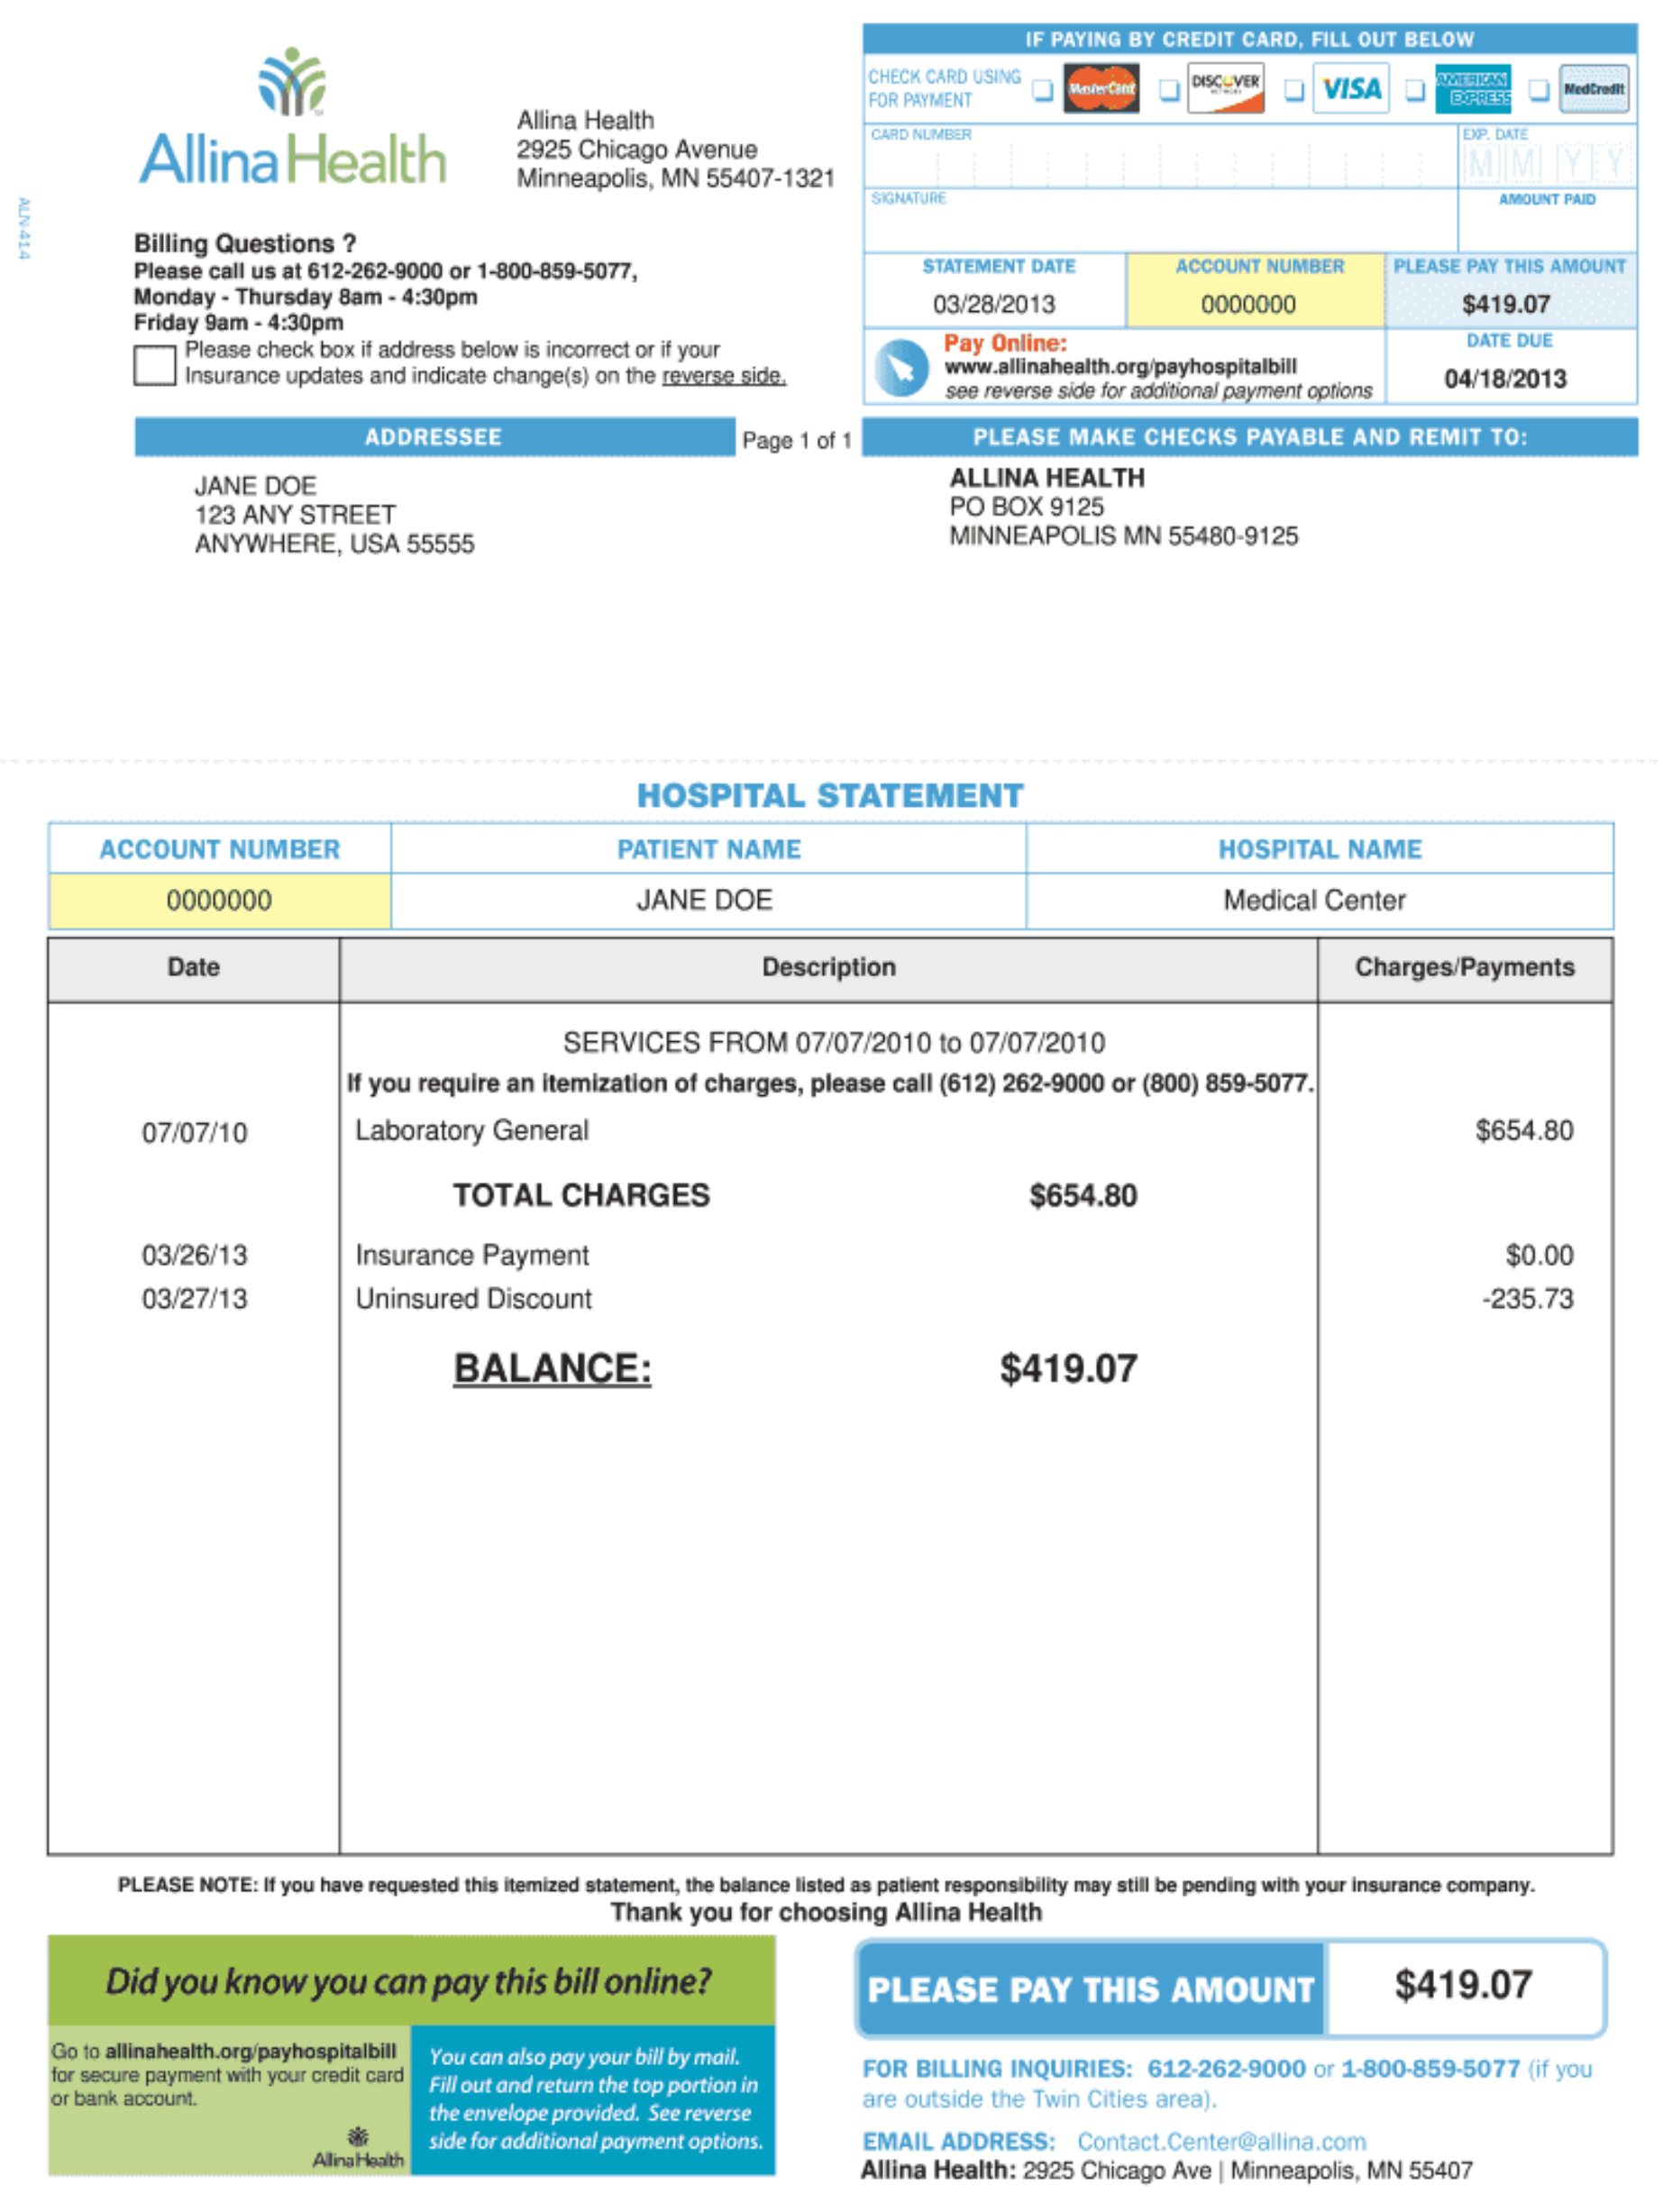

In [64]:
# image = Image.open('/content/form_example.jpg')
path  = '/content/dataset/training_data/images/img-7.jpg'
image = Image.open(path)
image = image.convert("RGB")
image

In [65]:
import numpy as np
import pytesseract
from PIL import Image, ImageDraw, ImageFont
import torch

from transformers import LayoutLMTokenizer
from transformers import LayoutLMForTokenClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': 'drive/MyDrive/UBIAI_layoutlm/data_UBIAI',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def model_load(PATH, num_labels):

    # model = LayoutLMForTokenClassification.from_pretrained(PATH, num_labels=num_labels)
    model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
    # model.load_state_dict(torch.load(PATH, map_location=device))
    model.to(device)
    model.eval()
    return model


def preprocess(image_path):

    image = Image.open(image_path)
    image = image.convert("RGB")

    width, height = image.size
    w_scale = 1000 / width
    h_scale = 1000 / height
    ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
    ocr_df = ocr_df.dropna().assign(left_scaled=ocr_df.left * w_scale,
                    width_scaled=ocr_df.width * w_scale,
                    top_scaled=ocr_df.top * h_scale,
                    height_scaled=ocr_df.height * h_scale,
                    right_scaled=lambda x: x.left_scaled + x.width_scaled,
                    bottom_scaled=lambda x: x.top_scaled + x.height_scaled)
    float_cols = ocr_df.select_dtypes('float').columns
    ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
    ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
    ocr_df = ocr_df.dropna().reset_index(drop=True)

    words = list(ocr_df.text)
    coordinates = ocr_df[['left', 'top', 'width', 'height']]
    actual_boxes = []
    for idx, row in coordinates.iterrows():
      x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
      actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box
      actual_boxes.append(actual_box)
    boxes = []
    for box in actual_boxes:
        boxes.append(normalize_box(box, width, height))
    return image, words, boxes, actual_boxes

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]


def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                sep_token_box=[1000, 1000, 1000, 1000],
                                pad_token_box=[0, 0, 0, 0]):
    width, height = image.size


    tokens = []
    token_boxes = []
    actual_bboxes = []  # we use an extra b because actual_boxes is already used
    token_actual_boxes = []
    for word, box, actual_bbox in zip(words, boxes, actual_boxes):
        word_tokens = tokenizer.tokenize(word)
        tokens.extend(word_tokens)
        token_boxes.extend([box] * len(word_tokens))
        actual_bboxes.extend([actual_bbox] * len(word_tokens))
        token_actual_boxes.extend([actual_bbox] * len(word_tokens))
    # Truncation: account for [CLS] and [SEP] with "- 2".
    special_tokens_count = 2
    if len(tokens) > args.max_seq_length - special_tokens_count:
        tokens = tokens[: (args.max_seq_length - special_tokens_count)]
        token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
        actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
        token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]
    # add [SEP] token, with corresponding token boxes and actual boxes
    tokens += [tokenizer.sep_token]
    token_boxes += [sep_token_box]
    actual_bboxes += [[0, 0, width, height]]
    token_actual_boxes += [[0, 0, width, height]]

    segment_ids = [0] * len(tokens)
    # next: [CLS] token
    tokens = [tokenizer.cls_token] + tokens
    token_boxes = [cls_token_box] + token_boxes
    actual_bboxes = [[0, 0, width, height]] + actual_bboxes
    token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
    segment_ids = [1] + segment_ids
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)
    # Zero-pad up to the sequence length.
    padding_length = args.max_seq_length - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * padding_length
    input_mask += [0] * padding_length
    segment_ids += [tokenizer.pad_token_id] * padding_length
    token_boxes += [pad_token_box] * padding_length
    token_actual_boxes += [pad_token_box] * padding_length
    assert len(input_ids) == args.max_seq_length
    assert len(input_mask) == args.max_seq_length
    assert len(segment_ids) == args.max_seq_length
    # assert len(label_ids) == args.max_seq_length
    assert len(token_boxes) == args.max_seq_length
    assert len(token_actual_boxes) == args.max_seq_length

    return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes


def convert_to_features(image, words, boxes, actual_boxes, model):
    input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image,
                                                                                                      words=words,
                                                                                                      boxes=boxes,
                                                                                                      actual_boxes=actual_boxes,
                                                                                                      tokenizer=tokenizer,
                                                                                                      args=args)
    input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
    attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
    token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
    bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
    #model=model_load(model_path,num_labels)
    outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
    token_predictions = outputs.logits.argmax(-1).squeeze().tolist()  # the predictions are at the token level
    print(token_predictions)

    word_level_predictions = []  # let's turn them into word level predictions
    final_boxes = []
    for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
        if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id,
                                                                tokenizer.sep_token_id,
                                                                tokenizer.pad_token_id]):
            # skip prediction + bounding box

            continue
        else:
            word_level_predictions.append(token_pred)
            final_boxes.append(box)
    return word_level_predictions, final_boxes

In [69]:
# model_path='/content/drive/MyDrive/MedBillOCR_Images/full_100epoch/layoutlm.pt'
model_path = '/content/drive/MyDrive/MedBillOCR_Images/Output_name/layoutlm.pt'
model = model_load(model_path,num_labels)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
image, words, boxes, actual_boxes = preprocess(path)

word_level_predictions, final_boxes=convert_to_features(image, words, boxes, actual_boxes, model)

[18, 22, 11, 2, 9, 9, 17, 13, 5, 6, 22, 9, 22, 12, 10, 11, 10, 8, 9, 22, 6, 19, 3, 10, 20, 9, 19, 6, 9, 9, 12, 14, 11, 14, 14, 11, 9, 9, 13, 14, 13, 14, 12, 12, 12, 14, 12, 9, 11, 9, 12, 7, 6, 5, 9, 9, 5, 6, 9, 22, 12, 12, 7, 7, 12, 9, 10, 7, 9, 9, 22, 7, 12, 22, 9, 12, 9, 12, 3, 11, 3, 9, 6, 9, 8, 19, 5, 14, 14, 12, 12, 3, 11, 14, 14, 22, 22, 22, 12, 14, 9, 10, 10, 11, 14, 12, 0, 14, 22, 21, 14, 11, 8, 5, 10, 9, 6, 8, 11, 22, 11, 9, 10, 6, 14, 10, 11, 11, 11, 11, 26, 19, 14, 8, 8, 22, 12, 3, 11, 13, 14, 8, 7, 12, 11, 6, 14, 11, 14, 22, 8, 12, 12, 12, 12, 14, 14, 12, 21, 18, 13, 20, 21, 20, 18, 12, 12, 12, 14, 11, 9, 12, 12, 12, 12, 20, 11, 12, 9, 22, 11, 16, 12, 10, 9, 12, 9, 14, 12, 10, 9, 11, 12, 14, 12, 14, 3, 12, 3, 17, 8, 3, 11, 26, 11, 6, 22, 22, 12, 22, 11, 10, 8, 9, 22, 8, 3, 10, 19, 22, 19, 22, 9, 9, 26, 9, 14, 9, 14, 8, 11, 20, 20, 20, 9, 22, 12, 11, 6, 9, 9, 3, 22, 9, 9, 9, 9, 22, 12, 12, 14, 9, 11, 11, 3, 14, 20, 9, 9, 20, 3, 9, 9, 26, 11, 9, 3, 9, 9, 2, 14, 9, 3, 22, 11, 

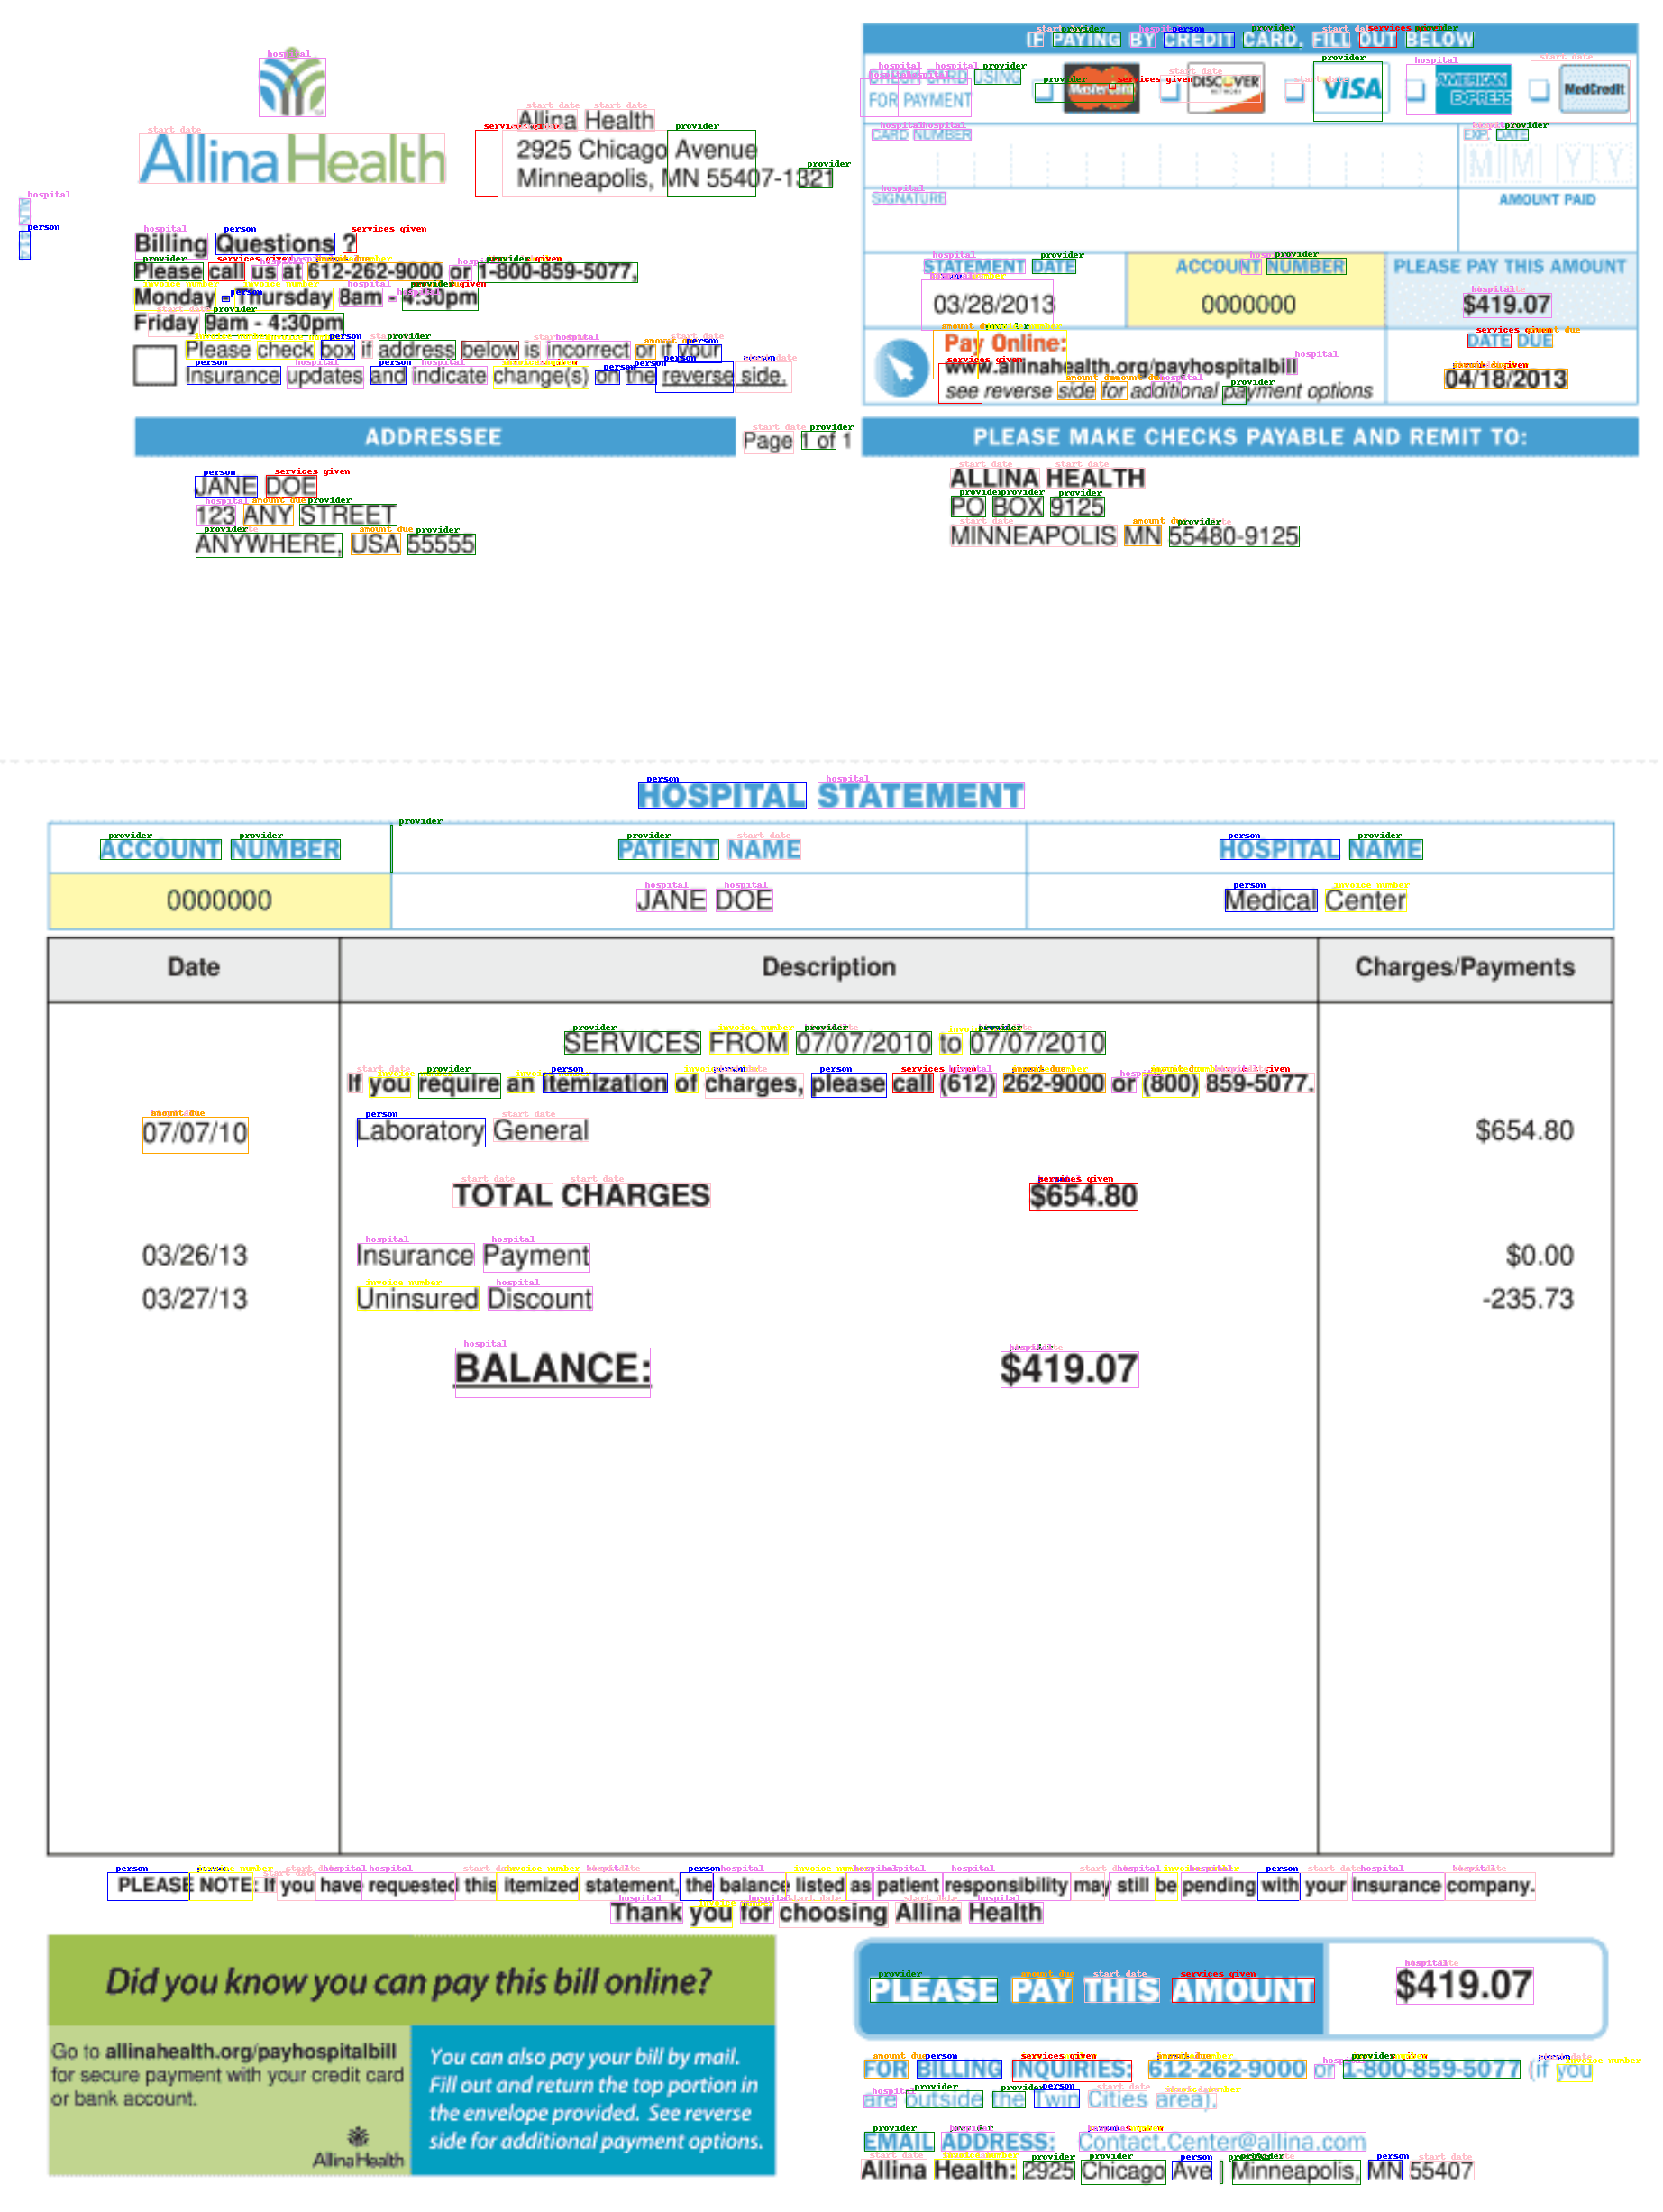

In [71]:
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return ""

label2color = {'person':'blue',
               'provider':'green',
               'amount due':'orange',
               'hospital':'violet',
               'services given':'red',
               'start date':'pink',
               'invoice number':'yellow',
               '':"brown"}

# label2color = {'question':'blue', 'answer':'green', 'header':'orange', '':'violet'}
for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
image

# Saving Model
